In [ ]:
## Inspect Environment
## RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 68.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install tensorflow-addons

In [ ]:
import os
import time
import sys
import pdb
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
print(tf.__version__)
print(matplotlib.__version__)

2.7.0
3.2.2


In [ ]:
# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd

In [ ]:
# Import Project Modules
module_path = os.path.abspath(os.path.join('.')) + "\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models"
print(f"Project module absolute path: {module_path}")
if module_path not in sys.path:
  sys.path.append(module_path)
# from data_utils import load_audio, splitsongs, hello_world2 #Every update requires Runtime Restart
# from data_utils import *
import data_utils

Project module absolute path: C:\Users\Zeyu Sun\Documents\GitHub\VAE-based-Music--Deep-Generative-Models


In [ ]:
%load Documents/GitHub/VAE-based-Music--Deep-Generative-Models/data_utils.py

## Data Loading

In [ ]:
DATA_PATH = "GENERATIVE_DATA/GTZAN/genres_original/"

## Data Loading
MAX_SIGNAL_LEN = 80000 #10240 # 80000

### Compressed 30 s audio
SAMPLE_RATE=  3000 #3000
DURATION= 30

QUANTIZATION_CHANNELS = 256 # 8bit

GENRES = {'metal': 0, 'disco': 1, 'classical': 2, 'rock': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'hiphop': 9}

In [ ]:
# DEV Test Loading file
# sample_sr = 3000
# [GTZAN] The Sample length is not strictly consistent
## TODO: padding?
sample = data_utils.load_audio(DATA_PATH+'hiphop/hiphop.00032.wav', sr=SAMPLE_RATE, duration=DURATION, mono=False)
print("Sample Signal Shape: {}, sample Rate: {}".format(sample.shape, SAMPLE_RATE))
ipd.Audio(sample, rate=SAMPLE_RATE)

Sample Signal Shape: (1, 89796), sample Rate: 3000


In [ ]:
ipd.Audio(sample[:, :MAX_SIGNAL_LEN], rate=SAMPLE_RATE)

In [ ]:
# sample.reshape(1, 90001)
print(np.amax(sample), np.amin(sample))

0.65754503 -0.67217755


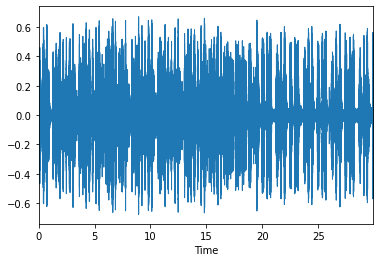

In [ ]:
## Waveplot
librosa.display.waveplot(sample[0], sr=sample_sr)

In [ ]:
import pdb

# def splitsongs(X, y, window = 0.05, overlap = 0.5):
#     # Empty lists to hold our results
#     temp_X = []
#     temp_y = []

#     # pdb.set_trace()

#     # Get the input song array size
#     xshape = X.shape[-1] # signal length
#     chunk = int(xshape*window)
#     offset = int(chunk*(1.-overlap))
    
#     # Split the song and create new ones on windows
#     if len(X.shape) == 1:
#     	spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
#     else:
#       spsong = [X[:, i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
#     for s in spsong:
#         # ignore the boundaries
#         if s.shape[-1] != chunk:
#             continue

#         temp_X.append(s)
#         temp_y.append(y)

#     # (#samples, 1, sample_chunk_size)
#     return np.array(temp_X), np.array(temp_y)

In [ ]:
## Original Sample Splitting
(sample_splits, sample_y_splits) = data_utils.splitsongs(sample, 'hiphop', window=1.0, overlap=0.0) # break into 3s interval
print(sample_splits.shape)
print(sample_y_splits.shape)

(1, 1, 15001)
(1,)


In [ ]:
X = np.array([[1,2,3,4], [2,3,4,5]])

In [ ]:
X.shape

(2, 4)

In [ ]:
X[:, :]

array([[1, 2, 3, 4],
       [2, 3, 4, 5]])

### Data Preprocessing

In [ ]:
def mu_law_encode(audio, quantization_channels):
  '''Quantizes waveform amplitudes.'''
    
  mu = float(quantization_channels - 1)
  # Perform mu-law companding transformation (ITU-T, 1988).
  # Minimum operation is here to deal with rare large amplitudes caused
  # by resampling.
  safe_audio_abs = np.minimum(np.abs(audio), 1.0)
  magnitude =np.log1p(mu * safe_audio_abs) / np.log1p(mu)
  signal = np.sign(audio) * magnitude
  # Quantize signal to the specified number of levels.
  return ((signal + 1) / 2 * mu + 0.5).astype(int)


def mu_law_decode(output, quantization_channels):
  '''Recovers waveform from quantized values.'''
  mu = quantization_channels - 1
  # Map values back to [-1, 1].
  signal = 2 * ((output).astype(float) / mu) - 1
  # Perform inverse of mu-law transformation.
  magnitude = (1 / mu) * ((1 + mu)**np.abs(signal) - 1)
  return np.sign(signal) * magnitude

In [ ]:
print(X_train[0])
t_encode = mu_law_encode(X_train[0], 256)
# np.minimum(X_train[0], 1.0)
print(t_encode)
ipd.Audio(X_train[0], rate=SAMPLE_RATE)


[[ 0.07863526  0.07143153 -0.06330642 ...  0.24468344  0.06142346
  -0.12215866]]
[[198 195  62 ... 223 192  48]]


In [ ]:
t_decode = mu_law_decode(t_encode, 256)
print(t_decode)
# recovered audio
ipd.Audio(t_decode, rate=SAMPLE_RATE)

[[ 0.08023245  0.06993862 -0.06378551 ... -0.05550349  0.0284032
  -0.08788023]]


In [ ]:
# ''' 
#   1. Split each single 30s song sample into smaller segment
#   2. convert each segment to melspectrogram
# '''
# def split_convert(X, y, sample_rate=3000, duration=30, max_signal_len=660000, split_window=1.0, split_overlap=0.0):
#     arr_waves, arr_genres = [], []
    
#     # Convert to spectrograms and split into small windows
#     for fn, genre in zip(X, y):
#         # for debug
#         print(f"Loading audio file: {fn}...")

#         # (1, sample_len)
#         signal = data_utils.load_audio(fn, sr=sample_rate, duration=duration)

#         # to avoid inconsistent image/spectragram size
#         signal = signal[:, :max_signal_len]

#         # Convert to dataset of spectograms/melspectograms
#         signals, y = splitsongs(signal, genre, window=split_window, overlap=split_overlap)

#         # Convert to "spec" representation
#         # specs = to_melspectrogram(signals, hop_length=512, n_fft=2048)

#         # Save files
#         print(signals.shape)
#         ## attach the forked list of sample segments
#         arr_waves.extend(signals)
#         arr_genres.extend(y)

#     # pdb.set_trace()

#     # print(len(arr_waves), arr_waves[0].shape)
#     # print(arr_genres.shape)

#     return np.array(arr_waves), np.array(arr_genres)
#     # return arr_waves, arr_genres

# '''
#  Generate data-set based on file_path for each audio sample
# - then preprocess and convert each sample accordingly
# '''
# def read_data(src_dir, genres, test_data_percentage=0.1, sample_rate=22050, duration=30, split_window=1.0, split_overlap=0.0, max_signal_len=660000):    
#     # Empty array of dicts with the processed features from all files
#     arr_fn = []
#     arr_genres = []

#     # Get file list from the folders
#     for x,_ in genres.items():
#         folder = src_dir + x
#         print(f"Loading Audio files under Genere: {x}")
#         for root, subdirs, files in os.walk(folder):
#             for file in files:
#                 file_name = folder + "/" + file

#                 ### TODO: some samples just don't load...
#                 if file_name.find('jazz/jazz.00054.wav') != -1:
#                   print(f"Skipping file: {file_name}...")
#                   continue

#                 # Save the file name and the genre
#                 arr_fn.append(file_name)
#                 # attach the label
#                 arr_genres.append(genres[x])
    
#     # Split into train and test
#     X_train, X_test, y_train, y_test = train_test_split(
#         arr_fn, arr_genres, test_size=test_data_percentage, random_state=42, stratify=arr_genres #data is split in a stratified fashion under genre label
#     )
    
#     # Split into small segments and convert to spectrogram
#     ## TODO: map this to TF DataSet process
    
#     print("Loading and Preprocessing Testing data......")
#     X_test, y_test = split_convert(X_test, y_test, sample_rate=sample_rate, duration=duration, max_signal_len=max_signal_len)

#     print("Loading and Preprocessing Training data......")
#     X_train, y_train = split_convert(X_train, y_train, sample_rate=sample_rate, duration=duration, max_signal_len=max_signal_len)

#     # return X_test, y_test
#     return X_train, y_train, X_test, y_test

In [ ]:
## No-Resampling: strict [-1, 1] waveform
X_train, y_train, X_test, y_test = data_utils.read_data(DATA_PATH, GENRES, sample_rate=22050, duration=15, max_signal_len=MAX_SIGNAL_LEN)

In [ ]:
# Loading....
# Read the data
X_train, y_train, X_test, y_test = data_utils.read_data(DATA_PATH, GENRES, sample_rate=SAMPLE_RATE, duration=DURATION, max_signal_len=MAX_SIGNAL_LEN)

In [ ]:
# Load Data From Single Genre
SINGLE_GENRE = {'jazz': 0}
X_train, y_train, X_test, y_test = data_utils.read_data(DATA_PATH, SINGLE_GENRE, sample_rate=SAMPLE_RATE, duration=DURATION, max_signal_len=MAX_SIGNAL_LEN, split_window=0.2, split_overlap=0.5)

Loading Audio files under Genere: jazz
Skipping file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00054.wav...
Loading and Preprocessing Testing data......
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00072.wav...
(9, 1, 16000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00020.wav...
(9, 1, 16000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00014.wav...
(9, 1, 16000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00051.wav...
(9, 1, 16000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00087.wav...
(9, 1, 16000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00075.wav...
(9, 1, 16000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00061.wav...
(9, 1, 16000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00093.wav...
(9, 1, 16000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00083.wav...

In [ ]:
print(type(X_train), X_train.shape, X_test.shape, y_train.shape, X_test.shape)

print(y_train[:5])
print(set(y_train), set(y_test))

## Debug Inspect samples
### 2: classical, 9: hip-hop
hiphop_idx = np.where(y_train==0)[0]
print(hiphop_idx[:10])
ipd.Audio(X_train[hiphop_idx[2]], rate=SAMPLE_RATE)
# ipd.Audio(X_train[hiphop_idx[2]], rate=22050) # raw file

<class 'numpy.ndarray'> (801, 1, 16000) (90, 1, 16000) (801,) (90, 1, 16000)
[0 0 0 0 0]
{0} {0}
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
## Value range
print(np.amax(X_train), np.amin(X_train))

0.7658354 -0.8005117


(7120000,) [-0.006466    0.01077177  0.01408311 ...  0.00973605  0.0095218
  0.01055633]
0


(array([1.310000e+02, 3.713000e+03, 4.166400e+04, 2.534820e+05,
        2.389383e+06, 3.986395e+06, 3.792050e+05, 5.941800e+04,
        6.416000e+03, 1.930000e+02]),
 array([-0.8005117 , -0.643877  , -0.48724228, -0.3306076 , -0.17397287,
        -0.01733816,  0.13929656,  0.29593128,  0.45256597,  0.6092007 ,
         0.7658354 ], dtype=float32),
 <a list of 10 Patch objects>)

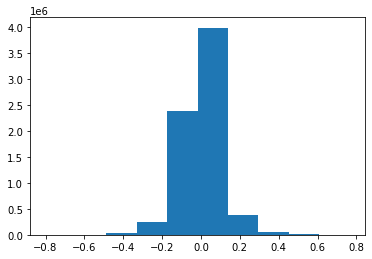

In [ ]:
## DEV: value distribution
print(X_train.flatten().shape, X_train.flatten())
# # value beyond [-1, 1]
print(np.sum(np.abs(X_train.flatten())>1))
# counts, bin_edges
# plt.hist(X_train[:2].squeeze())
plt.hist(X_train.flatten())
# plt.hist(np.random.randn(10000))

In [ ]:
## WaveForm Quantization
X_train_Q = mu_law_encode(X_train, QUANTIZATION_CHANNELS)
X_test_Q = mu_law_encode(X_test, QUANTIZATION_CHANNELS)

In [ ]:
print(np.amax(X_train_Q), np.amin(X_train_Q))

255 0


In [ ]:
BATCH_SIZE = 8
TRAIN_SHUFFLE_SIZE = 1000
NUM_GENERES = len(np.unique(y_train))

EPOCHS = 10
# set the dimensionality of the latent space to a plane for visualization later
LATENT_DIM = 2

print(NUM_GENERES)

1


In [ ]:
## Load to TF DataSet (numpy to TF Tensor)
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .shuffle(TRAIN_SHUFFLE_SIZE)
                 .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                 .batch(BATCH_SIZE))

## Using Quantization Data
# NCT -> NTC
# train_dataset = (tf.data.Dataset.from_tensor_slices((np.transpose(X_train_Q, [0,2,1]), y_train))
#                  .shuffle(TRAIN_SHUFFLE_SIZE)
#                  .batch(BATCH_SIZE))
# test_dataset = (tf.data.Dataset.from_tensor_slices((np.transpose(X_test_Q, [0,2,1]), y_test))
#                  .batch(BATCH_SIZE))


In [ ]:
### Example batch
sample_batch, sample_labels = next(iter(train_dataset))
print(sample_batch.shape)
print(sample_labels.shape, sample_labels)
print(sample_batch[0].numpy().squeeze())

(8, 1, 16000)
(8,) tf.Tensor([0 0 0 0 0 0 0 0], shape=(8,), dtype=int32)
[-0.11050642 -0.07092468 -0.05445001 ... -0.04504539 -0.04805756
 -0.04519051]


#### Training Data Samples (1 per genre)

In [ ]:
## Single Genre Case
train_samples = X_train[:10]
print(train_samples.shape, train_samples[0])
print(X_train.shape)

(10, 1, 16000) [[-0.006466    0.01077177  0.01408311 ... -0.13000278 -0.32065722
  -0.2626283 ]]
(801, 1, 16000)


In [ ]:
idx_to_genres = {v:k for (k, v) in GENRES.items()}

In [ ]:

# create a dict of each unique entry and the associated indices
generes_train_idx = {v: np.where(y_train == v)[0].tolist()[:6] for v in np.unique(y_train)}

print(generes_train_idx)

train_samples = []

for i in range(NUM_GENERES):
  train_samples.append(X_train[int(generes_train_idx[i][0])])
  # Quantization Version
  # train_samples.append(X_train_Q[int(generes_train_idx[i][0])])

# Numpy Array
train_samples = np.stack(train_samples, axis=0)
print(train_samples.shape, train_samples[0])

{0: [0, 1, 2, 3, 4, 5]}
(1, 1, 16000) [[-0.006466    0.01077177  0.01408311 ... -0.13000278 -0.32065722
  -0.2626283 ]]


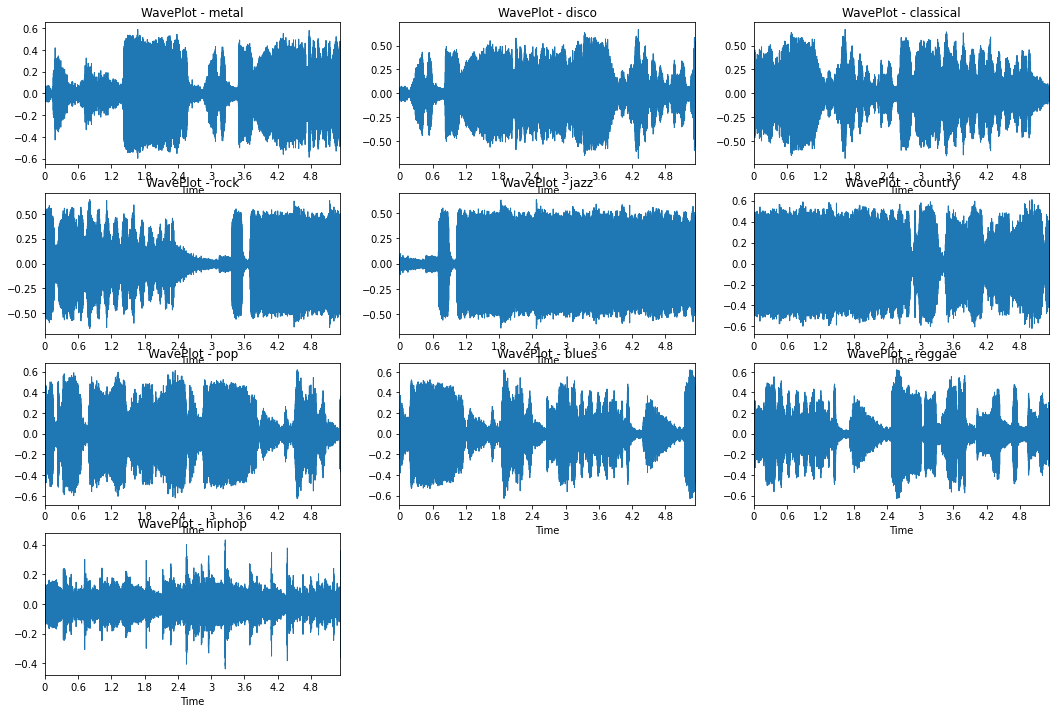

In [ ]:
fig = plt.figure(figsize=(18, 12))

for i in range(train_samples.shape[0]):
  
  # mel_spec_dB = librosa.amplitude_to_db(train_samples[i].squeeze()*MAX_SPEC, ref=np.max)
  
  plt.subplot(4, 3, i + 1)

  librosa.display.waveplot(train_samples[i].squeeze(), sr=3000)
  ## Quantization Version
  # librosa.display.waveplot(mu_law_decode(train_samples[i], QUANTIZATION_CHANNELS).squeeze(), sr=3000)

  plt.title(f"WavePlot - {idx_to_genres[i]}")
  # plt.tight_layout()
  
plt.show()

In [ ]:
#### Validation between Epoches
'''
 sample latent z based on actual test data x
'''
def generate_and_save_waves(model, epoch, test_sample, if_quantized=False, channel_last=False):
  # mean, logvar = model.encode(test_sample)
  # # print('(Test Image generation) Epoch: {}, encoded mean: {}, encoded log var: {}'.format(epoch, mean, logvar))
  # z = model.reparameterize(mean, logvar) # The actual sample happens here
  # predictions = model.sample(z) # equals to directly decode here

  # Direct Reconstruction (x -> x')
  input = test_sample
  if channel_last:
    input = np.transpose(test_sample, [0,2,1])
  predictions = model(input).numpy()
  print("Reconstructed Output: ", predictions.shape)
  fig = plt.figure(figsize=(18, 12))
  ret = []

  if if_quantized:
    # recover int waveform to float waveform
    # Greedy Sampling
    predictions = np.argmax(predictions, axis=-1)
    print("Sampled quantized: ", predictions.shape, predictions[0])

    predictions = mu_law_decode(predictions, QUANTIZATION_CHANNELS)

    print("Max: {}, Min: {}".format(np.amax(predictions), np.amin(predictions)))

  for i in range(predictions.shape[0]):
    waves = predictions[i]
    plt.subplot(4, 3, i + 1)
    # plt.figure(figsize=(6, 3))
    # print("MEL SPEC DB: {}".format(mel_spec_dB.shape))
    if i==9:
      print("X': ", waves.squeeze())
      print(f"X range: [{np.amax(waves)}, {np.amin(waves)}]")

    librosa.display.waveplot(waves.squeeze(), sr=SAMPLE_RATE)
    plt.title(f"WavePlot - {idx_to_genres[i]}")
    # plt.tight_layout()
    ret.append(predictions[i])
    
  plt.show()

  return ret

In [ ]:
sample_batch.shape
tf.math.reduce_variance(tf.squeeze(sample_batch), axis=0)

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([0.01445164, 0.00416692, 0.00174624, ..., 0.00765455, 0.0043453 ,
       0.00430631], dtype=float32)>

## Model Structure

In [ ]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__()
    
        if type=='encode':
            self.conv1a = tf.keras.layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = tf.keras.layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = tf.keras.layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = tf.keras.layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = tf.keras.layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = tf.keras.layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim, seq_len=MAX_SIGNAL_LEN):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.seq_len = seq_len
    # Conv and ConvTranse layer used, but 1-D instead
    '''
    Input shape: 3+D tensor with shape: batch_shape + (steps, input_dim)

    Output shape:3+D tensor with shape: batch_shape + (new_steps, filters) 
    - new_steps decided by kernel size, padding and strides (K, P, S)
    '''
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(1,self.seq_len)),
            # What's the point of applying stride?
            tf.keras.layers.Conv1D(64,1,1), # original config: layers.Conv1D(64,1,2)
            Resnet1DBlock(64,1),
            tf.keras.layers.Conv1D(128,1,1),
            Resnet1DBlock(128,1),
            tf.keras.layers.Conv1D(128,1,1),
            Resnet1DBlock(128,1),
            tf.keras.layers.Conv1D(256,1,1),
            Resnet1DBlock(256,1),
            # No activation
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim+latent_dim, activation='relu')

        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(256 * 1 , activation='relu'),
            tf.keras.layers.Reshape(target_shape=(1,256)),
            Resnet1DBlock(512,1,'decode'),
            tf.keras.layers.Conv1DTranspose(512,1,1),
            Resnet1DBlock(256,1,'decode'),
            tf.keras.layers.Conv1DTranspose(256,1,1),
            Resnet1DBlock(128,1,'decode'),
            tf.keras.layers.Conv1DTranspose(128,1,1),
            Resnet1DBlock(64,1,'decode'),
            tf.keras.layers.Conv1DTranspose(64,1,1),
            # No activation
            tf.keras.layers.Conv1DTranspose(self.seq_len,1,1),
        ]
    )

    ### Loss
    self.mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    ## Metrics
    self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
    self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss/latent_loss")

  '''
    Properties
  '''
  @property
  def metrics(self):
      return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def call(self, inputs):
      #dum call
      # print("Don't Call this dude...")
      # return inputs
      z_mean, z_log_var = self.encode(inputs)
      z = self.reparameterize(z_mean, z_log_var)
      reconstruction = self.decode(z)

      return reconstruction


  # @tf.function
  def train_step(self, data):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    # For Debug
    # tf.print("[Debug]Input Data Shape: ", data[0].shape, data[1].shape)

    with tf.GradientTape() as tape:
      loss, reconstruction_loss, kl_loss = self.compute_loss(data[0])
      # print(f"Training Loss to Back Prop: {loss}")
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.total_loss_tracker.update_state(loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }


  def compute_loss(self, x):
    '''
    @param x: the input data
    '''
    # DEBUG
    # print(f"======= [DEBUG] This is the propoer KL based Loss Computation...")
    z_mean, z_log_var = self.encode(x)
    z = self.reparameterize(z_mean, z_log_var)
    # (B, 1, LEN/T)
    reconstruction = self.decode(z) # Non-Activated Linear output: raw logits

    # print("X: ", x)
    # print("X': ",re)

    ## TODO: Under MSE, is this still cross_ent?
    # mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    # reconstruction_loss = tf.reduce_mean(
    #     ## TODO: loss exploding...
    #     tf.reduce_sum(
    #         # self.mse(x, reconstruction), axis=(1) # sum up all pixles and average by instance
    #         # self.mse(tf.transpose(x, perm=[0,2,1]), tf.transpose(reconstruction, perm=[0,2,1])), axis=1
    #     #     # mse(x, reconstruction)/self.train_var.squeeze(), axis=(1, 2) # Scaled by training data-set 'pixel-level' variance sum up all pixles and average by instance
    #     )
    #     # #ENT (Binary Cross Entropy) 
    #     ##TODO: loss is stable, but the constructed audio is almost Zero Array
    #     # tf.reduce_sum(
    #     #     tf.keras.losses.binary_crossentropy(x, reconstruction, from_logits=True), axis=(1)
    #     # )

    #     # tf.reduce_sum(
    #     #     tf.nn.sigmoid_cross_entropy_with_logits(logits=reconstruction, labels=x), axis=(1,2)
    #     # )

    #     # mse(y_true=x, y_pred=reconstruction)
    # ) #/ tf.math.reduce_variance(x)
    reconstruction_loss = (
                # tf.reduce_mean((x - reconstruction) ** 2) / tf.math.reduce_variance(x)
                tf.reduce_mean((x - reconstruction) ** 2 / tf.math.reduce_variance(tf.squeeze(x), axis=0))
    )

    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss

    print(f"Reconstruction Loss/MSE: {reconstruction_loss}, KL: {kl_loss}")

    return total_loss, reconstruction_loss, kl_loss

  # @tf.function
  def sample(self, eps=None):
      if eps is None:
          # (Batch, DIM_Z)
          eps = tf.random.normal(shape=(200, self.latent_dim))
      return self.decode(eps, apply_sigmoid=True)
  # @tf.function
  def encode(self, x):
      mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
      return mean, logvar

  # @tf.function
  def reparameterize(self, mean, logvar):
      # eps = tf.random.normal(shape=mean.shape)
      # return eps * tf.exp(logvar * .5) + mean
        # $$$$ sample the stochastic epsilon
      print(f"[DEBUG] Mean: {mean.shape}, LogVar shape: {logvar.shape}")
      # eps = tf.random.normal(shape=mean.shape)
      ## Get Shape when BatchSize == None
      batch = tf.shape(mean)[0]
      dim = tf.shape(mean)[1]
      eps = tf.random.normal(shape=(batch, dim))

      return eps * tf.exp(logvar * .5) + mean

  # @tf.function
  def decode(self, z, apply_sigmoid=False):
      logits = self.decoder(z)
      if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
      return logits

In [ ]:
class CVAE_mulaw(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE_mulaw, self).__init__()
    self.latent_dim = latent_dim

    self.T = MAX_SIGNAL_LEN//32 # for now...
    # Conv and ConvTranse layer used, but 1-D instead
    '''
    Input shape: 3+D tensor with shape: batch_shape + (steps, input_dim)

    Output shape:3+D tensor with shape: batch_shape + (new_steps, filters) 
    - new_steps decided by kernel size, padding and strides (K, P, S)
    '''
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(MAX_SIGNAL_LEN, 1)),
            # What's the point of applying stride?
            tf.keras.layers.Conv1D(64, 7, strides=2, padding='same', activation='relu'), # original config: layers.Conv1D(64,1,2)
            # Resnet1DBlock(64,1),
            tf.keras.layers.Conv1D(128, 7, strides=2, padding='same', activation='relu'),
         
            tf.keras.layers.Conv1D(256, 7, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(512, 7, strides=2, padding='same', activation='relu'),
         
            tf.keras.layers.Conv1D(1024, 7, strides=2, padding='same', activation='relu'),

            # Resnet1DBlock(128,1),
            # tf.keras.layers.Conv1D(128,1,1),
            # Resnet1DBlock(128,1),
            # tf.keras.layers.Conv1D(256,1,1),
            # Resnet1DBlock(256,1),
            # # No activation
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim+latent_dim, activation='relu')

        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(1024 * self.T, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(self.T, 1024)),
            # Resnet1DBlock(512,1,'decode'),
            tf.keras.layers.Conv1DTranspose(1024,7,strides=2, padding='same', activation='relu'),
            # Resnet1DBlock(256,1,'decode'),
            tf.keras.layers.Conv1DTranspose(512,7,strides=2, padding='same', activation='relu'),
            # Resnet1DBlock(128,1,'decode'),
            tf.keras.layers.Conv1DTranspose(512,7,strides=2, padding='same', activation='relu'),
            # Resnet1DBlock(64,1,'decode'),
            tf.keras.layers.Conv1DTranspose(256,7,strides=2, padding='same', activation='relu'),
            # No activation
            tf.keras.layers.Conv1DTranspose(256,7,strides=2, padding='same')
            # tf.keras.layers.Conv1DTranspose(MAX_SIGNAL_LEN,1,1),
        ]
    )
    ## Metrics
    self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
    self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss/latent_loss")

  '''
    Properties
  '''
  @property
  def metrics(self):
      return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def call(self, inputs):
      #dum call
      # print("Don't Call this dude...")
      # return inputs
      z_mean, z_log_var = self.encode(inputs)
      z = self.reparameterize(z_mean, z_log_var)
      reconstruction = self.decode(z)

      return reconstruction


  # @tf.function
  def train_step(self, data):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    # For Debug
    # tf.print("[Debug]Input Data Shape: ", data[0].shape, data[1].shape)

    with tf.GradientTape() as tape:
      loss, reconstruction_loss, kl_loss = self.compute_loss(data[0])
      # print(f"Training Loss to Back Prop: {loss}")
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.total_loss_tracker.update_state(loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }


  def compute_loss(self, x):
    '''
    @param x: the input data
    '''
    # DEBUG
    # print(f"======= [DEBUG] This is the propoer KL based Loss Computation...")
    z_mean, z_log_var = self.encode(x)
    z = self.reparameterize(z_mean, z_log_var)
    # (B, 1, LEN/T)
    reconstruction = self.decode(z) # Non-Activated Linear output: raw logits

    # print("X: ", x)
    # print("X': ",reconstruction)

    ## TODO: Under MSE, is this still cross_ent?
    SENT = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    reconstruction_loss = tf.reduce_mean(
        ## ENT
        tf.reduce_mean(
            SENT(y_true=x, y_pred=reconstruction), axis=(1) # sum up all timesteps and average by instance
            
        )

    )
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss

    print(f"Reconstruction Loss/MSE: {reconstruction_loss}, KL: {kl_loss}")

    return total_loss, reconstruction_loss, kl_loss

  # @tf.function
  def sample(self, eps=None):
      if eps is None:
          # (Batch, DIM_Z)
          eps = tf.random.normal(shape=(200, self.latent_dim))
      return self.decode(eps, apply_sigmoid=True)
  # @tf.function
  def encode(self, x):
      mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
      return mean, logvar

  # @tf.function
  def reparameterize(self, mean, logvar):
      # eps = tf.random.normal(shape=mean.shape)
      # return eps * tf.exp(logvar * .5) + mean
        # $$$$ sample the stochastic epsilon
      print(f"[DEBUG] Mean: {mean.shape}, LogVar shape: {logvar.shape}")
      # eps = tf.random.normal(shape=mean.shape)
      ## Get Shape when BatchSize == None
      batch = tf.shape(mean)[0]
      dim = tf.shape(mean)[1]
      eps = tf.random.normal(shape=(batch, dim))

      return eps * tf.exp(logvar * .5) + mean

  # @tf.function
  def decode(self, z, apply_sigmoid=False):
      logits = self.decoder(z)
      if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
      return logits

In [ ]:
# test_model = CVAE(LATENT_DIM)
test_model_mulaw = CVAE_mulaw(LATENT_DIM)
test_model_mulaw.encoder.summary()
test_model_mulaw.decoder.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_125 (Conv1D)         (None, 5120, 64)          512       
                                                                 
 conv1d_126 (Conv1D)         (None, 2560, 128)         57472     
                                                                 
 conv1d_127 (Conv1D)         (None, 1280, 256)         229632    
                                                                 
 conv1d_128 (Conv1D)         (None, 640, 512)          918016    
                                                                 
 conv1d_129 (Conv1D)         (None, 320, 1024)         3671040   
                                                                 
 flatten_25 (Flatten)        (None, 327680)            0         
                                                                 
 dense_50 (Dense)            (None, 4)               

In [ ]:
## Sparse ENT
sent = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
# t_input =np.transpose(sample_batch, [0,2,1])
t_input = sample_batch
print(t_input.shape)
t_enc_out = test_model_mulaw.encode(t_input)
print(t_enc_out[0].shape, t_enc_out[1].shape)

t_z = test_model_mulaw.reparameterize(t_enc_out[0], t_enc_out[1])
t_dec_out = test_model_mulaw.decode(t_z)
print(t_dec_out.shape)
print(t_dec_out[0].numpy().squeeze())

sent_loss = sent(y_true = t_input, y_pred=t_dec_out)
print(sent_loss)
print(tf.reduce_mean(tf.reduce_sum(sent_loss, axis=(1))))

(8, 10240, 1)
(8, 2) (8, 2)
[DEBUG] Mean: (8, 2), LogVar shape: (8, 2)
(8, 10240, 256)
[[-1.38944761e-05 -2.71151330e-05 -2.25403674e-05 ... -3.23878157e-05
   4.10092616e-05 -2.46149302e-05]
 [ 1.13457409e-05 -1.25218849e-05  3.36456651e-07 ...  1.52377397e-05
  -1.62153374e-05 -3.74157717e-05]
 [ 1.86521538e-05  2.41791695e-05 -5.52883394e-05 ... -1.03482434e-05
   7.15088026e-05  3.84304622e-05]
 ...
 [-7.02515026e-05 -1.13792164e-04 -5.47849741e-05 ...  5.18574379e-05
   2.18278637e-05 -1.18161333e-04]
 [ 4.99666348e-05  4.87594880e-05  2.05105698e-05 ... -1.08233828e-04
   5.16204236e-05  3.81574537e-05]
 [-4.72312677e-05 -2.56602507e-05 -6.12211225e-05 ...  1.08731765e-04
  -3.61613420e-05  1.66290156e-05]]
tf.Tensor(
[[5.5451365 5.545192  5.545243  ... 5.545044  5.545173  5.545203 ]
 [5.5451775 5.5451894 5.545184  ... 5.545194  5.545163  5.54522  ]
 [5.5451303 5.5451508 5.545266  ... 5.545105  5.545086  5.545115 ]
 ...
 [5.545197  5.5451136 5.545141  ... 5.545179  5.5450935 5.54

In [ ]:
# sent(y_true = t_input.squeeze(), y_pred=t_dec_out)
test_model_mulaw.compute_loss(t_input)

[DEBUG] Mean: (8, 2), LogVar shape: (8, 2)
Reconstruction Loss/MSE: 5.545178413391113, KL: 0.6160596609115601


(<tf.Tensor: shape=(), dtype=float32, numpy=6.161238>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.5451784>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.61605966>)

[DEBUG] Mean: (10, 2), LogVar shape: (10, 2)
Reconstructed Output:  (10, 10240, 256)
Sampled quantized:  (10, 10240) [217  90  23 ... 153 103 152]
Max: 1.0, Min: -1.0
X':  [ 0.03290828 -0.10067457 -0.2249029  ... -0.03290828 -0.839699
 -0.01991909]


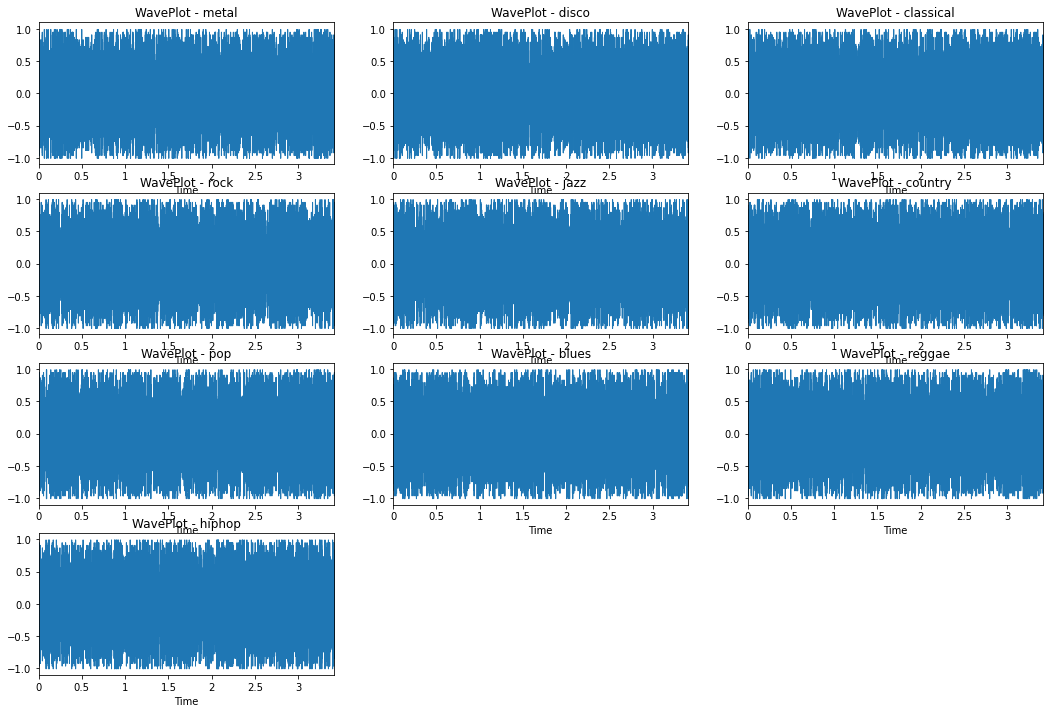

[array([ 0.18836539, -0.01611234, -0.36528735, ...,  0.0079664 ,
        -0.00746046,  0.00746046]),
 array([-0.06679517, -0.29312969,  0.00606819, ..., -0.001754  ,
        -0.76941909,  0.00344624]),
 array([-0.34957404, -1.        ,  0.02702748, ..., -0.03134082,
        -0.157662  ,  0.00344624]),
 array([ 0.21516427, -0.76941909, -0.2249029 , ..., -0.03290828,
        -0.839699  ,  0.39884044]),
 array([ 0.21516427, -0.10067457, -0.2249029 , ..., -0.03290828,
        -0.839699  ,  0.39884044]),
 array([ 5.55034883e-02, -1.00674568e-01,  2.54499597e-03, ...,
        -8.62115957e-05,  1.31861176e-01,  3.77374362e-03]),
 array([ 1.79329882e-02, -1.61123401e-02, -3.65287350e-01, ...,
         7.96640444e-03, -4.50431954e-04, -5.42170153e-01]),
 array([ 5.55034883e-02, -1.00674568e-01,  2.54499597e-03, ...,
        -8.62115957e-05,  1.31861176e-01,  3.77374362e-03]),
 array([ 0.18836539, -0.01611234, -0.36528735, ...,  0.0079664 ,
        -0.00746046,  0.00746046]),
 array([ 0.03290828

In [ ]:
generate_and_save_waves(test_model_mulaw, 0, train_samples, if_quantized=True, channel_last=True)

In [ ]:
test_model = CVAE(LATENT_DIM, seq_len=sample_batch.shape[-1])

In [ ]:
## Encoder forward pass
test_enc_out = test_model.encode(sample_batch)
print(test_enc_out[0].shape, test_enc_out[1].shape) # (B, L), (B, L)

(8, 2) (8, 2)


In [ ]:
## Decoder forward pass
test_z = test_model.reparameterize(test_enc_out[0], test_enc_out[1])
test_dec_out = test_model.decode(test_z)
print(test_dec_out.shape)
print(test_dec_out[0].numpy().squeeze())

[DEBUG] Mean: (8, 2), LogVar shape: (8, 2)
(8, 1, 16000)
[ 0.00206466  0.00912436 -0.00310351 ... -0.00124097  0.00489881
  0.00337104]


In [ ]:
test_model.encoder.summary()
test_model.decoder.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_120 (Conv1D)         (None, 1, 64)             1024064   
                                                                 
 resnet1d_block_80 (Resnet1D  (None, 1, 64)            4166      
 Block)                                                          
                                                                 
 conv1d_123 (Conv1D)         (None, 1, 128)            8320      
                                                                 
 resnet1d_block_81 (Resnet1D  (None, 1, 128)           16518     
 Block)                                                          
                                                                 
 conv1d_126 (Conv1D)         (None, 1, 128)            16512     
                                                                 
 resnet1d_block_82 (Resnet1D  (None, 1, 128)         

In [ ]:
test_losses = test_model.compute_loss(sample_batch)
test_losses

[DEBUG] Mean: (8, 2), LogVar shape: (8, 2)
Reconstruction Loss/MSE: 1.2004485130310059, KL: 0.0003591887652873993


(<tf.Tensor: shape=(), dtype=float32, numpy=1.2008077>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.2004485>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00035918877>)

In [ ]:
## DEV
sce = tf.nn.sigmoid_cross_entropy_with_logits(logits=test_dec_out, labels=sample_batch)
# tf.reduce_sum(sce, axis=[1,2])
sce

<tf.Tensor: shape=(8, 1, 16000), dtype=float32, numpy=
array([[[0.6941829 , 0.6916291 , 0.69364303, ..., 0.6944369 ,
         0.6921241 , 0.692491  ]],

       [[0.6939932 , 0.68892086, 0.6959867 , ..., 0.69362295,
         0.6910483 , 0.6924067 ]],

       [[0.6938787 , 0.6899807 , 0.6937961 , ..., 0.69244313,
         0.69115716, 0.6934558 ]],

       ...,

       [[0.6929504 , 0.6926661 , 0.6928803 , ..., 0.6937115 ,
         0.6928989 , 0.69238156]],

       [[0.6933449 , 0.6922809 , 0.69338185, ..., 0.6929594 ,
         0.6925477 , 0.69321823]],

       [[0.6930021 , 0.69203335, 0.6923002 , ..., 0.6942287 ,
         0.6935753 , 0.6910251 ]]], dtype=float32)>

In [ ]:
bce = tf.keras.losses.binary_crossentropy(y_true=sample_batch, y_pred=test_dec_out, from_logits=True)
bce

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.69314367],
       [0.69314855],
       [0.6931407 ],
       [0.6931434 ],
       [0.6931412 ],
       [0.69314647],
       [0.69314563],
       [0.6931455 ]], dtype=float32)>

In [ ]:
MSE = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
mse = MSE(sample_batch, test_dec_out)
mse

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.00779997],
       [0.00915722],
       [0.01242573],
       [0.01017875],
       [0.00400491],
       [0.00879888],
       [0.00146545],
       [0.00377645]], dtype=float32)>

In [ ]:
mse_t_level = MSE(tf.transpose(sample_batch, perm=[0,2,1]), tf.transpose(test_dec_out, perm=[0,2,1]))
tf.reduce_sum(mse_t_level, axis=1)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([124.799576, 146.51544 , 198.81169 , 162.86002 ,  64.07851 ,
       140.78204 ,  23.447138,  60.423214], dtype=float32)>

[DEBUG] Mean: (10, 2), LogVar shape: (10, 2)
Reconstructed Output:  (10, 1, 16000)
X':  [-0.00023646 -0.00347882  0.00285911 ...  0.00102149 -0.00119047
 -0.0022217 ]
X range: [0.008050902746617794, -0.008578686974942684]


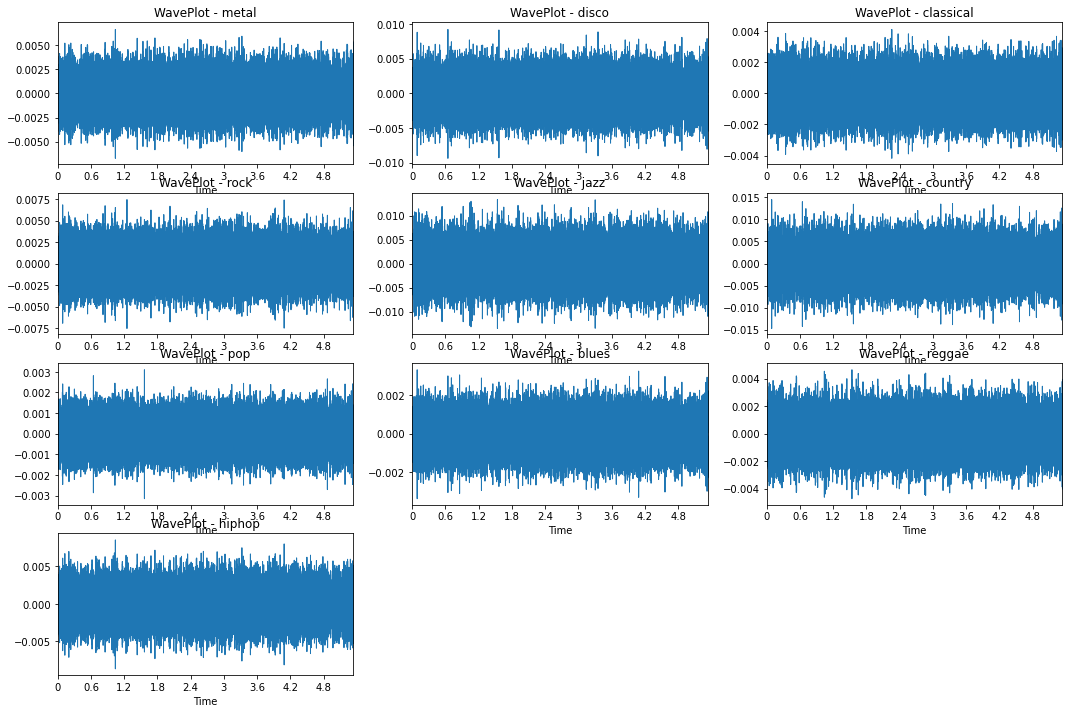

In [ ]:
_ = generate_and_save_waves(test_model, 0, train_samples, if_quantized=False)

## Training

#### Training with 'FIT'

In [ ]:
# Callbacks
class VAEMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, **kwargs):
        super(VAEMonitor, self).__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
      if epoch % 5 == 0:
        print("[DEBUG] This is Callback Monitor: End of Epoch", epoch)
        generate_and_save_waves(self.model, epoch, train_samples)
        # generate_and_save_waves(self.model, epoch, train_samples, if_quantized=True, channel_last=True)

vae_monitor = VAEMonitor()

In [ ]:
del test_model_mulaw

NameError: ignored

In [ ]:
### Quantization with Sparse ENT loss
vae_mulaw_model = CVAE_mulaw(256)
# vae_mulaw_model.encoder.summary()
vae_mulaw_model.compile(optimizer=tf.keras.optimizers.Adam())

vae_mulaw_model.fit(train_dataset, epochs=100, callbacks=[vae_monitor])

(1, 16000)
Epoch 1/300
[DEBUG] Mean: (None, 128), LogVar shape: (None, 128)
Reconstruction Loss/MSE: Tensor("Mean:0", shape=(), dtype=float32), KL: Tensor("Mean_1:0", shape=(), dtype=float32)
[DEBUG] Mean: (None, 128), LogVar shape: (None, 128)
Reconstruction Loss/MSE: Tensor("Mean:0", shape=(), dtype=float32), KL: Tensor("Mean_1:0", shape=(), dtype=float32)
 99/101 [============================>.] - ETA: 0s - loss: 1.1984 - reconstruction_loss: 1.1898 - kl_loss: 0.0018[DEBUG] This is Callback Monitor: End of Epoch 0
[DEBUG] Mean: (10, 128), LogVar shape: (10, 128)
Reconstructed Output:  (10, 1, 16000)
X':  [-6.4309193e-03 -3.9060944e-04  2.6715854e-03 ... -5.2008689e-03
  1.4372898e-05 -4.2942856e-03]
X range: [0.013952208682894707, -0.017900686711072922]


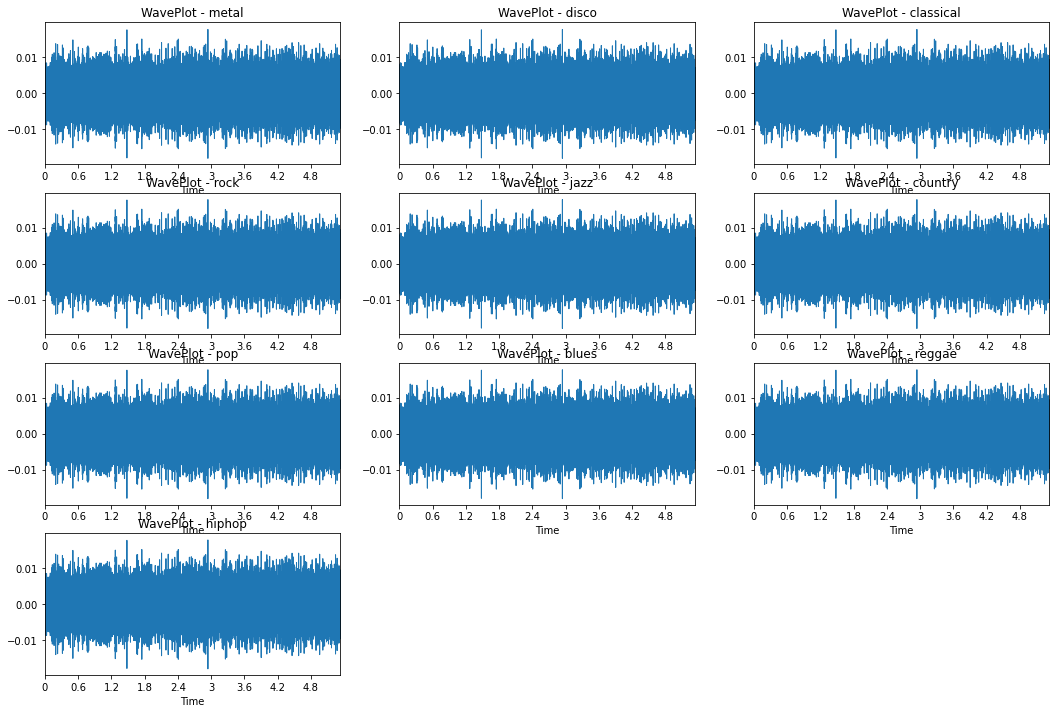

101/101 [==============================] - 8s 39ms/step - loss: 1.1982 - reconstruction_loss: 1.1877 - kl_loss: 0.0017
Epoch 2/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1865 - reconstruction_loss: 1.1847 - kl_loss: 3.4545e-05
Epoch 3/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1882 - reconstruction_loss: 1.1848 - kl_loss: 7.9787e-06
Epoch 4/300
101/101 [==============================] - 3s 25ms/step - loss: 1.1858 - reconstruction_loss: 1.1854 - kl_loss: 1.8046e-05
Epoch 5/300
101/101 [==============================] - 3s 25ms/step - loss: 1.1856 - reconstruction_loss: 1.1856 - kl_loss: 2.5325e-09
Epoch 6/300
100/101 [============================>.] - ETA: 0s - loss: 1.1862 - reconstruction_loss: 1.1875 - kl_loss: 0.0000e+00[DEBUG] This is Callback Monitor: End of Epoch 5
[DEBUG] Mean: (10, 128), LogVar shape: (10, 128)
Reconstructed Output:  (10, 1, 16000)
X':  [-0.00602676 -0.00848261 -0.0043449  ...  0.00146739 -0.00586608
 -0.00

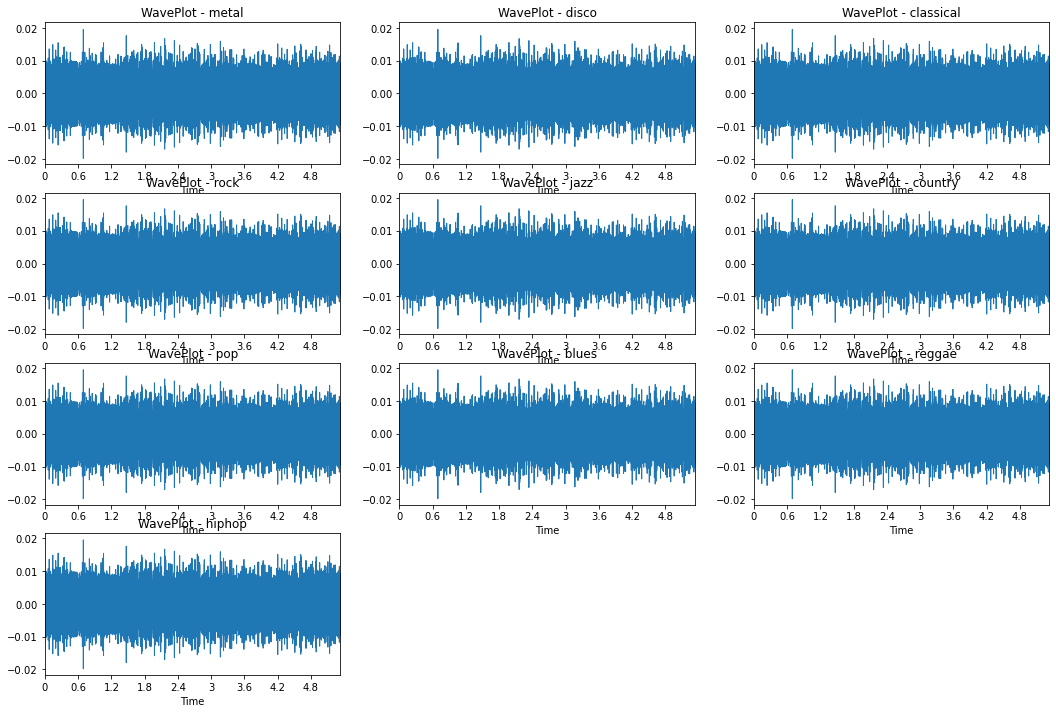

101/101 [==============================] - 4s 36ms/step - loss: 1.1862 - reconstruction_loss: 1.1857 - kl_loss: 0.0000e+00
Epoch 7/300
101/101 [==============================] - 3s 27ms/step - loss: 1.1862 - reconstruction_loss: 1.1850 - kl_loss: 0.0000e+00
Epoch 8/300
101/101 [==============================] - 3s 25ms/step - loss: 1.1862 - reconstruction_loss: 1.1852 - kl_loss: 0.0000e+00
Epoch 9/300
101/101 [==============================] - 3s 25ms/step - loss: 1.1864 - reconstruction_loss: 1.1865 - kl_loss: 0.0000e+00
Epoch 10/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1860 - reconstruction_loss: 1.1857 - kl_loss: 0.0000e+00
Epoch 11/300
100/101 [============================>.] - ETA: 0s - loss: 1.1868 - reconstruction_loss: 1.1877 - kl_loss: 0.0000e+00[DEBUG] This is Callback Monitor: End of Epoch 10
[DEBUG] Mean: (10, 128), LogVar shape: (10, 128)
Reconstructed Output:  (10, 1, 16000)
X':  [-0.01161007 -0.00343894  0.00229671 ...  0.00106256  0.00225078

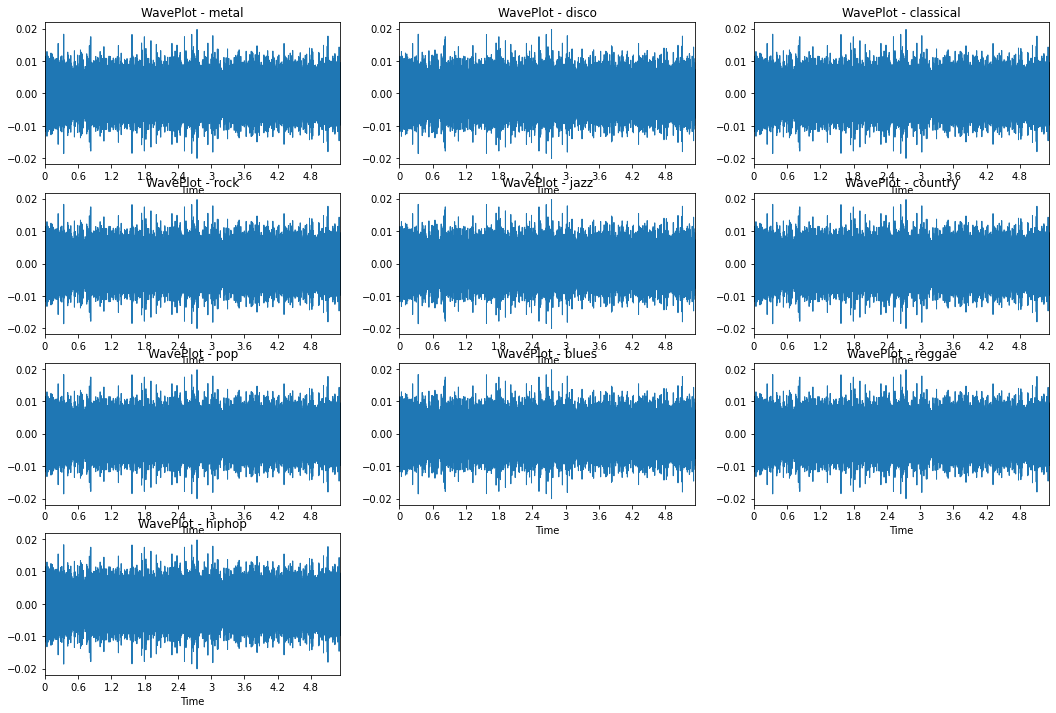

101/101 [==============================] - 4s 36ms/step - loss: 1.1868 - reconstruction_loss: 1.1858 - kl_loss: 0.0000e+00
Epoch 12/300
101/101 [==============================] - 3s 27ms/step - loss: 1.1853 - reconstruction_loss: 1.1845 - kl_loss: 0.0000e+00
Epoch 13/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1870 - reconstruction_loss: 1.1852 - kl_loss: 0.0000e+00
Epoch 14/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1858 - reconstruction_loss: 1.1847 - kl_loss: 0.0000e+00
Epoch 15/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1849 - reconstruction_loss: 1.1834 - kl_loss: 0.0000e+00
Epoch 16/300
 99/101 [============================>.] - ETA: 0s - loss: 1.1861 - reconstruction_loss: 1.1869 - kl_loss: 0.0000e+00[DEBUG] This is Callback Monitor: End of Epoch 15
[DEBUG] Mean: (10, 128), LogVar shape: (10, 128)
Reconstructed Output:  (10, 1, 16000)
X':  [-0.01141249 -0.00203195  0.00586998 ...  0.00246756 -0.00504

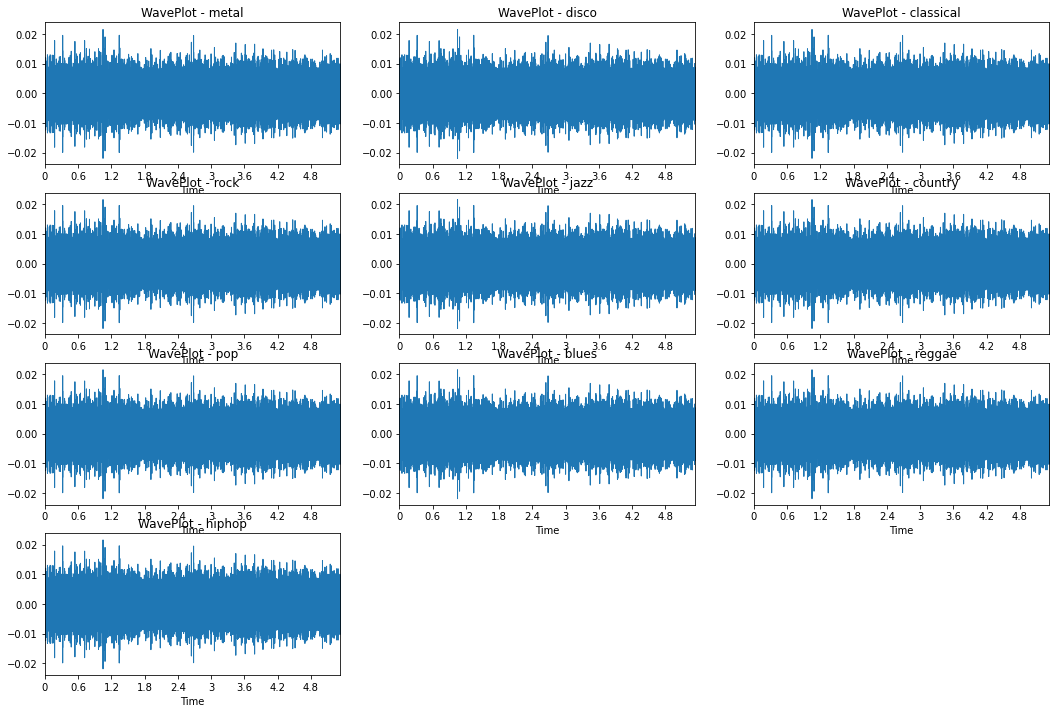

101/101 [==============================] - 4s 36ms/step - loss: 1.1861 - reconstruction_loss: 1.1850 - kl_loss: 0.0000e+00
Epoch 17/300
101/101 [==============================] - 3s 27ms/step - loss: 1.1883 - reconstruction_loss: 1.1847 - kl_loss: 0.0000e+00
Epoch 18/300
101/101 [==============================] - 3s 25ms/step - loss: 1.1850 - reconstruction_loss: 1.1843 - kl_loss: 0.0000e+00
Epoch 19/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1868 - reconstruction_loss: 1.1861 - kl_loss: 0.0000e+00
Epoch 20/300
101/101 [==============================] - 3s 25ms/step - loss: 1.1854 - reconstruction_loss: 1.1842 - kl_loss: 0.0000e+00
Epoch 21/300
101/101 [==============================] - ETA: 0s - loss: 1.1858 - reconstruction_loss: 1.1850 - kl_loss: 0.0000e+00[DEBUG] This is Callback Monitor: End of Epoch 20
[DEBUG] Mean: (10, 128), LogVar shape: (10, 128)
Reconstructed Output:  (10, 1, 16000)
X':  [-0.01322974 -0.00516184  0.00175682 ... -0.00184802 -0.00046

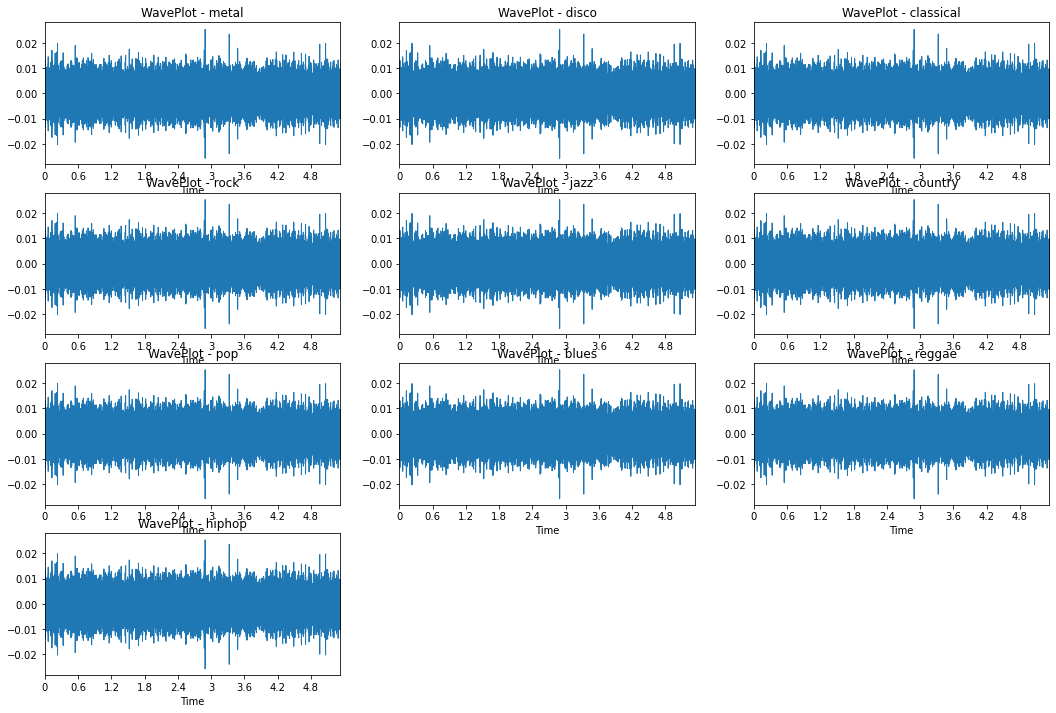

101/101 [==============================] - 4s 35ms/step - loss: 1.1858 - reconstruction_loss: 1.1850 - kl_loss: 0.0000e+00
Epoch 22/300
101/101 [==============================] - 3s 25ms/step - loss: 1.1846 - reconstruction_loss: 1.1857 - kl_loss: 0.0000e+00
Epoch 23/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1852 - reconstruction_loss: 1.1846 - kl_loss: 0.0000e+00
Epoch 24/300
101/101 [==============================] - 3s 25ms/step - loss: 1.1864 - reconstruction_loss: 1.1850 - kl_loss: 0.0000e+00
Epoch 25/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1855 - reconstruction_loss: 1.1844 - kl_loss: 0.0000e+00
Epoch 26/300
100/101 [============================>.] - ETA: 0s - loss: 1.1888 - reconstruction_loss: 1.1891 - kl_loss: 0.0000e+00[DEBUG] This is Callback Monitor: End of Epoch 25
[DEBUG] Mean: (10, 128), LogVar shape: (10, 128)
Reconstructed Output:  (10, 1, 16000)
X':  [-0.00399326 -0.00491286 -0.00754265 ... -0.00750852 -0.00264

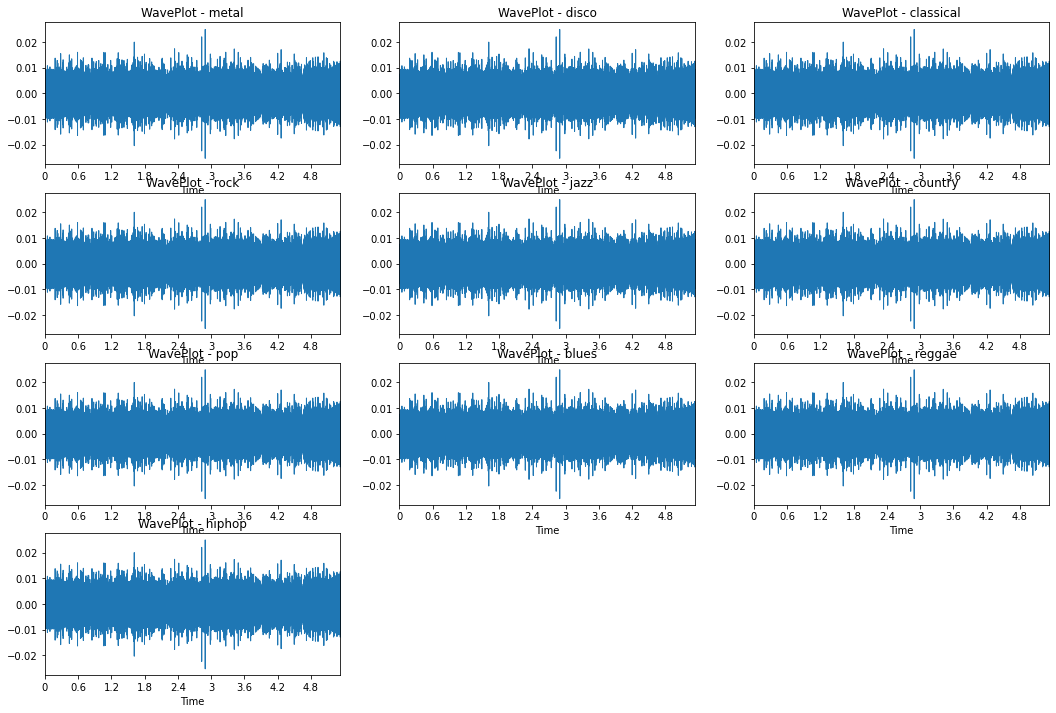

101/101 [==============================] - 4s 35ms/step - loss: 1.1888 - reconstruction_loss: 1.1872 - kl_loss: 0.0000e+00
Epoch 27/300
101/101 [==============================] - 3s 27ms/step - loss: 1.1881 - reconstruction_loss: 1.1852 - kl_loss: 0.0000e+00
Epoch 28/300
101/101 [==============================] - 3s 26ms/step - loss: 1.1866 - reconstruction_loss: 1.1855 - kl_loss: 0.0000e+00
Epoch 29/300
101/101 [==============================] - 3s 25ms/step - loss: 1.1857 - reconstruction_loss: 1.1855 - kl_loss: 0.0000e+00
Epoch 30/300
 50/101 [=============>................] - ETA: 1s - loss: 1.1846 - reconstruction_loss: 1.1864 - kl_loss: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
input_shape = sample_batch.shape[1:]
print(input_shape)
vae_model = CVAE(128, seq_len=sample_batch.shape[-1])

# Callback 0: Learning Rate Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1, min_lr=0.0000001, min_delta=1.0)
vae_model.compile(optimizer=tf.keras.optimizers.Adam())
# vae_model.fit(train_dataset, epochs=300, callbacks=[vae_monitor, reduce_lr])

vae_model.fit(train_dataset, epochs=300, callbacks=[vae_monitor])

# vae_model.fit(train_dataset, epochs=100)

In [ ]:
val_loss_history = []
train_loss_history = []


# generate_and_save_images(model, 0, val_samples)

for epoch in range(1, 2):
  start_time = time.time()
  for (step, train_data) in enumerate(train_dataset):
    # print(train_x.shape, train_y.shape)
    train_loss = vae_model.train_step(train_data)
    train_loss_history.append(train_loss)

    if step%50 == 0:

      print('========= Epoch:{} Batch:{}, Train Loss for minimization: {}, time elapse for current epoch: {}'
        .format(epoch, step, train_loss, time.time() - start_time))
  end_time = time.time()

[DEBUG] Mean: (10, 128), LogVar shape: (10, 128)
Reconstructed Output:  (10, 1, 16000)
X':  [-0.00679433 -0.00852856 -0.00349274 ... -0.00326649 -0.00280233
  0.00209506]
X range: [0.020305614918470383, -0.022064723074436188]


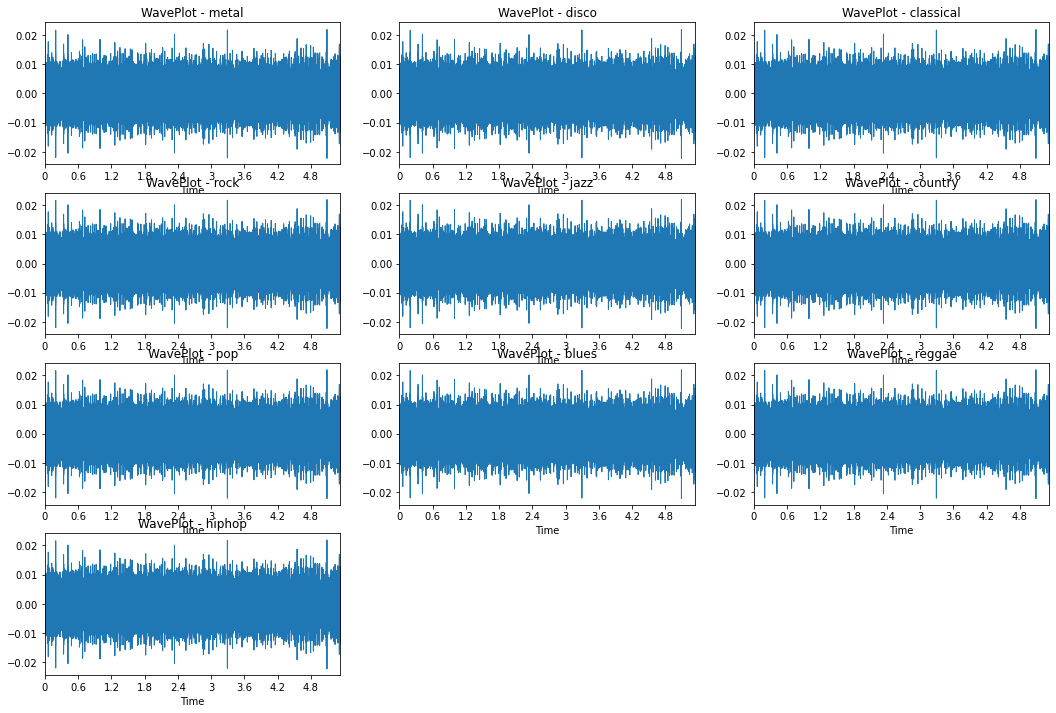

In [ ]:
#### Inspect reconstructed sample
recon_train_samples = generate_and_save_waves(vae_model, 0, train_samples)

In [ ]:
recon_train_samples = generate_and_save_waves(vae_mulaw_model, 0, train_samples, if_quantized=True, channel_last=True)

In [ ]:
print(recon_train_samples[0].shape)

(1, 80000)


In [ ]:
ipd.Audio(recon_train_samples[0], rate=SAMPLE_RATE)

## Causal and Dilated Convolutions

In [ ]:
## Trick to slice the sequence length/time series dimension


out_width = tf.shape(value)[1] - (filter_width - 1) * dilation
result = tf.slice(restored,
                  [0, 0, 0],
                  [-1, out_width, -1]) # -1 denotes dims[i].size() - begin[i]
                                       # If size[i] is -1, all remaining elements in dimension i are included in the slice